# PHÂN TÍCH CẢM XÚC VỚI LSTMs

- Điểm: 
- Nhận xét:

## Dẫn nhập

### Giới thiệu bài toán
Trong thực trạng nhiều công ty thương mại điện tử phát triển nở rộ ngày nay, việc thu thập đánh giá từ các bình luận của người dùng là rất cần thiết. Các bình luận này có chứa nhiều thông tin quan trọng, có thể giúp các trang web dễ dàng lọc, đề xuất các mặt hàng, địa điểm phù hợp với từng người dùng và đánh giá chất lượng sản phẩm cũng như dịch vụ của các đối tác.

Với số lượng bình luận từ hàng nghìn tới hàng trăm nghìn, việc phân loại các bình luận từ người dùng không phải là điều dễ dàng, và đòi hỏi rất nhiều nhân lực. Cụ thể ở đây, ta quan tâm đến cảm xúc (tích cực/tiêu cực) gắn liền với các bình luận, từ đó suy ra cảm nhận của người dùng và đánh giá chất lượng các sản phẩm.

Cùng sự phát triển của AI và các phương pháp machine learning, hiện nay chúng ta có thể giải quyết bài toán này bằng các mô hình Deep Learning với độ chính xác có thể sánh ngang với khả năng đọc hiểu của con người.

Trong bài tập này, ta sẽ tập trung vào phân tích các bình luận tiếng Việt để tìm ra cảm xúc được thể hiện trong bình luận.
![](https://drive.google.com/uc?export=view&id=16m7rYwl40I0CBJKWlu44CyAXEMflcF9R)
![](https://drive.google.com/uc?export=view&id=1MSEwafiJ7hIoRD4QEzL5umCK8FqlAojN)


### Hướng giải quyết bài toán

Ta sẽ dùng mạng **LSTM** (Long Short-Term Memory) để giải quyết bài toán **Sentiment Analysis**  (phân tích cảm xúc) trên dữ liệu văn bản.

Đầu vào nhận được là một văn bản.

Đầu ra cần trả về là loại cảm xúc được thể hiện trong văn bản: tích cực, tiêu cực, hay trung lập (positive - negative - neutral). Trong phạm vi của bài tập này, chúng ta chỉ quan tâm đến hai cảm xúc positive và negative.

![caption](https://drive.google.com/uc?export=view&id=1cg-W4IXMKP9jfpCcADKXqXwpgEV19I-f)

### Hướng dẫn làm bài
Ở bài tập này, các bạn sẽ được yêu cầu hoàn thành phần code cần thực hiện ở các mục TODO. Ở mỗi mục TODO sẽ có các code cell. Trong đó, các bạn sẽ code phần đáp án của mình giữa 2 phần:
```python
### START CODE HERE ###
<phần bài làm>
### END CODE HERE ###
```

### Cách đánh giá mô hình
Mô hình luyện được sẽ được đánh giá trên tập dữ liệu gồm 3000 bình luận (được giấu nhãn) với độ đo F1 score. 

Các bạn nộp dự đoán của mình qua [Kaggle](https://www.kaggle.com/c/vietai-f7-assignment-4)

### Cách tính điểm

Điểm tổng của bài tập sẽ là:
$$
Score = solution\times{70\%} + test\_score \times{30\%}
$$
Trong đó:
- solution: điểm của phần bài tập được hoàn thành dưới dạng các TODO (thang điểm 100)
- test_score: điểm trên leaderboard của Kaggle, sẽ được so sánh với  baseline model (mô hình mức cơ sở) (thang điểm 100)

## Hướng giải quyết bài toán

### Tập dữ liệu

Trong assignment này, chúng ta sử dụng tập dữ liệu review trên trang web Foody với khoảng 30,000 mẫu được gán nhãn, trong đó có khoảng 15,000 mẫu positive và 15,000 mẫu negative (Nguồn: https://streetcodevn.com/blog/dataset).

Tập dữ liệu này có thể được tải bằng đoạn code bên dưới:

In [ ]:
# Tải data
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1eoMIeJoIdITRsW94IwyAx4O2sDZprBSW', dest_path='./assignment4-data.zip', unzip=True)

Unzipping...Done.


Cấu trúc của folder vừa tải xuống:

In [ ]:
data_dir = 'Assignment4'
!ls {data_dir} #Các lệnh bắt đầu bằng ! trong colab code cell tương đương các lệnh chạy trực tiếp trên terminal

sample_submission.csv  test.csv  train.csv  words_list.npy  word_vectors.npy


Trong đó:
- **train.csv**: file csv chứa 27,000 mẫu dữ liệu đã gán nhãn
- **test.csv**: file chứa 3000 mẫu test giấu nhãn, dùng để dự đoán và nộp kết quả lên kaggle
- **sample_submission.csv**: file mẫu thể hiện hình thức nộp kết quả
- **word_list.npy**: chứa danh sách các từ tiếng Việt đã xử lý
- **word_vectors.npy**: chứa vectors  biểu diễn các từ trong **word_list.npy**

### Phân tích bài toán dưới góc nhìn Word Vectors


Nếu như chúng ta giữ nguyên định dạng kí tự của văn bản đầu vào thì rất khó để thực hiện các thao tác toán học, như tính tích vô hướng (dot product) , đưa vào hàm softmax, hay các thuật toán trên Neural Net như backpropagation.

Vậy nên, thay vì sử dụng chuỗi kí tự, ta sẽ thay đổi  định dạng của văn bản đầu vào bằng các vector biểu diễn, để thuận tiện cho việc tính toán.

![Word2Vec](https://drive.google.com/uc?export=view&id=12xKP6pFzDzj-0ToZX-27RjOhRcMFrfeb)

Trong hình minh hoạ ở trên, dữ liệu đầu vào là câu "Tôi ăn ... rồi" với tổng cộng 16 từ. Giả sử ta có thể mã hóa mỗi tiếng thành một vector D chiều, ví dụ như:

```
Tôi = [0.2, 0, 0.8, 0.5,]
ăn = [0, 0.6, 0.3, -0.1]
rồi = [0.5, 0.2, 0.1, -0.7]
với D = 4
```

Vậy, cả câu "Tôi ăn ... rồi" có thể được biểu diễn bằng một ma trận 16*D chiều.
```
[[0.2, 0, 0.8, 0.5]
[0, 0.6, 0.3, -0.1]
.
.
.
[0.5, 0.2, 0.1, -0.7]]
```

Để ánh xạ từ một **từ** sang một **vector**, chúng ta sử dụng một bộ vector biểu diễn từ đã được chuẩn bị sẵn.

### Import các thư viện cần thiết

In [ ]:
import os
import sys
import time
import datetime
import math

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

In [ ]:
tf.__version__

'2.4.1'

## Chuẩn bị dữ liệu huấn luyện

### Tải dữ liệu 
Sau đây ta tiến hành tải dữ liệu từ file `train.csv`

In [ ]:
pd.options.display.max_colwidth=1000
train_df = pd.read_csv(os.path.join(data_dir, 'train.csv'))
train_df.head()

,id,text,class
0,dee6dfc5,"Đến quán 2 lần thôi , rất là thích !\nQuán tuy nằm trong hẻm nhưng rất dễ tìm , quán rộng_rãi thoáng mát sạch_sẽ .\nNhân_viên phục_vụ nhiệt_tình , siêu dễ_thương .\nThực_đơn phong_phú đa_dạng , giá siêu rẻ .\nThức_ăn nêm nếm hợp_khẩu vị , ngon_miệng .\nDesert ngọt vừa , không quá ngấy , rất ngon .\nTrà sữa , uyên_ương thơm và đúng vị mình đã từng uống ở HongKong .\nNói_chung điểm 10 cho chất_lượng , thích quán lắm !",1
1,800813f5,Đến quán vào tối chủ_nhật . Có band hát . Khá ổn . Tuy_nhiên không_gian tầng 1 hơi hẹp . Ngồi cả ra vỉa_hè . Đồ uống ko ngon lămz,0
2,6553e47f,Phục_vụ lâu quá mặc_dù khách rất vắng .\nĐợi gần 15p mới mang được ly cà_phê ra . Ông này chỉ khéo quảng_bá chứ với mình chắc không quay lại_nữa .,0
3,b45a1ff1,"Ko gian bé_tí , quán chật_chội , đông người nên phục_vụ chưa tốt . Đồ uống bình_thường ( đặc_biệt khi so với giá_cả ) và ko có gì đặc_sắc cả .",0
4,f92694b0,"Khi mình order , đặt bánh thì nhận được sự tiếp_đãi , tư_vấn và nói_chuyện rất gần_gũi , rất nhiệt_tình .\nBánh thì rất tuyệt , nhân béo , rau_câu không dùng phẩm . Sau_này có dịp sinh_nhật , mình sẽ order mẫu lớn .\nChúc các bạn làm_ăn phát_đạt !",1


In [ ]:
print('Number of train samples in total:', len(train_df))

Number of train samples in total: 27000


In [ ]:
print('Number of positives:', np.sum(train_df['class']==1))
print('Number of negatives:', np.sum(train_df['class']==0))

Number of positives: 13518
Number of negatives: 13482


Dữ liệu gồm 3 cột: `id`, `text` và `class`. Trong đó:
- `id`: id của mẫu dữ liệu
- `text`: dữ liệu văn bản, đã được tiền xử lý để gộp từ và dấu câu
- `class`: nhãn của dữ liệu, 1 là positive, 0 là negative

Để giúp hiểu rõ hơn về dữ liệu, ta có thể hiển thị một số review bất kỳ như sau. Các bạn có thể thử chạy các code cell ở dưới nhiều lần để thấy sự đa dạng của các bình luận trong tập dữ liệu (về độ dài, cách gõ, hành văn, ngôn từ, *vân vân*)

5 review tích cực

In [ ]:
sample_positive = train_df[train_df['class'] == 1].sample(5)
sample_positive

,id,text,class
18756,0657b517,"< a class = ' hashtag-link ' href = ' / ho-chi-minh/hashtag/U-Nu-F-189002 ' > # U_Nù F< / a > ood Em không nhớ lí_do tại_sao quen , nhưng lại ấn_tượng về cách trang_trí của quán , khi đó phục_vụ thoải_mái , đem về lại không bị bể hay hư gì vẫn còn nguyên , tako thì chỉ cần hăm lên là ngon tuyệt , ... vẫn nhớ hương_vị của quán , nhưng laijkhoong có dịp để ăn T . T # U_Nù_Food < a class = ' hashtag-link ' href = ' / ho-chi-minh/hashtag/ngon-4569 ' > # ngon </a> < a class = ' hashtag-link ' href = ' / ho-chi-minh/hashtag/bo-189000 ' > # bổ </a> < a class = ' hashtag-link ' href = ' / ho-chi-minh/hashtag/re-186596 ' > # rẻ </a> < a class = ' hashtag-link ' href = ' / ho-chi-minh/hashtag/phuc-vu-186756 ' > # phục_vụ </a> < a class = ' hashtag-link ' href = ' / ho-chi-minh/hashtag/de-thuong-189001 ' > # dễ_thương </a>",1
26601,828405ed,"Quán không_gian đẹp , rộng_rãi , nhân_viên lịch_sự , dễ_thương . Có ban_công ngoài_trời ngồi cũng rất thoáng .\nẤn_tượng một_số món ngon như : bò cuộn nấm kim châm , gỏi rong_biển , cá_hồi sốt chanh dây , cơm_chiên mei , sò điệp nướng sốt chua_ngọt ... giá_cả cũng mềm",1
17982,ad26e418,"Hạt điều thơm ngon , tuy có vài hạt hơi hơi khó bóc vỏ_lụa tí nhưng nhìn_chung là ăn ngon , hum kia thấy trên webtretho nên mua văn_phòng 3 túi hạt điều ăn thử còn mấy con bợn đồng_nghiệp , hờ hờ\nMà cái ấn_tượng đầu_tiên của mình là cái túi vải , bình_thường toàn thấy đựng trong hủ nhựa không đây là lần đầu_tiên thấy đựng trong túi vải lun á , quá ấn_tượng",1
25294,de696e3e,"Ôi trời kem chanh bạc_hà thì hấp_dẫn khỏi_phải_nói . Ăn vào mát lên đến tận óc , chả phải nghĩ để dừng chân ăn vài cái .\nNgay ở bờ hồ nên cứ đi qua là phải làm miếng cho đỡ thèm .\nMình mới ăn kem chanh bạc_hà ở đây . 6k hay 6,5 k 1 cái gì đó .\nCác bác bán hàng thì vô_cảm rồi vì đông người mua ; )",1
3075,f66a804c,"Lần đầu_tiên đến đây . Lúc đầu nghe tên hẻm bia chắc pub hay qán mở nhạc ầm_ầm . Vô quán ôi_thôi rồi nhậu mà chơi nhạc giao_hưởng không lời . Sau khi ngồi đc tầm 15 ' xin a quản_lý đổi đc thì đc nhạc trẻ k lời nhẹ_nhàng như r & b . Thôi kệ đỡ hơn lúc đầu\nMón ăn_ở đây thì mình khen hết_lời luôn . Ngon 👍\nCơm xào tỏi ngon . Thơm_phức .\nGỏi hải_sản ngon . Vừa_miệng . Chua_chua ngọt ngọt nhìu hải_sản .\nMì xào hải_sản lại ngon . Nói_chung là nó ngon : ) )\nBò nhúng dấm ở đây mình cực_kì thích . Có chén trứng để đổ vô nồi . Trông hơi lạ nhưng ăn vô ngon cực . Nước trong nồi chua_ngọt vừa_miệng lắm luôn . Mình múc húp mún nửa nồi haha\nNói_chung ngoài Âm_nhạc ra thì ở đây là điểm nhậu đáng đến . Nhớ thay_đổi nhạc nha chứ nhạc vậy nhậu là ức_chế sùi bọt mép xỉu luôn đó\nPhục_vụ : Nhanh_nhẹn . Chị phục_vụ cho mình dễ_thương lắm\nGiá_cả : K rẻ nhưng củng k qá mắc . Chầu nhậu như_vậy là ok\nKhông_gian : Thích_hợp đàn_đúm bạn_bè , họp hội",1


5 review tiêu cực


In [ ]:
sample_negative = train_df[train_df['class'] == 0].sample(5)
sample_negative

,id,text,class
3738,fb74bb9e,"Mình mua phiếu rồi hí_hửng gọi người_nhà đi ăn trưa . Đã cẩn_thận gọi điện cho hotline của quán 2 lần mà k nhấc máy ( cũng_như k gọi lai ) . Thế_là đến , gửi xe . Vô quán . Quán vắng_tanh dù đã 11h trưa . Quản_lý mặt lạnh_lùng check mã_số phiếu như thật . Mình gọi thêm vài món . Ngồi . Chờ . Một lúc sau , một bé phục_vụ lấy hết dũng_cảm ra xin_lỗi ? ? ? Vì quán sửa_chữa nên k có những món trong thực_đơn . Chỉ có cơm văn_phòng . Ok cơm văn_phòng chị cũng xơi . Chờ . 15 phút sau chẳng có thực_đơn cơm văn_phòng nào cả . Tẽn_tò ra về .\nChẳng hiểu nổi .",0
6398,75ec0460,"Nhân_viên làm_việc mà như_chơi . Trước khi đến ăn mình đã book chỗ nhưng khi mình đến thì cả nhân_viên và quản_lí đều nói rằng mình không có book chỗ rồi làm khó_dễ . Sau đó bàn_luận với nhau sao đó rồi vẫn cho mình vào ăn mà nhân_viên thì thái_độ khó_chịu , hỏi không thèm trả_lời rồi còn nói "" Chỉ được ăn đến 6h thôi "" trong khi đó lúc mình tới đã là 5h rồi . Thái_độ quá tệ như_vậy làm mình ăn cũng không thấy ngon_miệng nữa . Mình đi ăn trả tiền chứ đâu phải ăn free đâu mà_lại có thái_độ như_vậy . Còn về phần đồ_ăn thì chỉ có khoảng 7,8 món chạy trên băng_chuyền thôi . Nói_tóm_lại sẽ không_bao_giờ quay lại quán này nữa ! 👎",0
16948,35a52cfc,"Quán nằm ở dốc hàng than , là quán vỉa_hè nên bạn sẽ phải đi gửi xe ở đầu dốc . Ấn_tượng đầu với quán của mình hơi tệ , quán hơi đông chờ mãi mới có chỗ , sau khi ngồi thì_phải 1 lúc lâu sau mới có người dọn bàn và gọi đồ . Sau khi gọi thì_phải 20 phút sau mới có đồ . Muốn được gọi thêm đồ cũng khó , chắc là do đông nên mình muốn gọi nhân_viên không có ai , mà nếu có thì cũng nhận được câu trả_lời là : "" bạn đợi mình chút "" . Về chất_lượng thì cũng tạm ổn , nước lẩu hơi nhạt 1 chút . Chỗ ngồi hơi sát nhau chắc là do đông quá .",0
7262,8a107430,Đây là lần thứ 2 mình đến đây . Thấy hôm_nay quán có khuyến_mãi nên mình đến . Đến quán gọi hai ly matcha nhưng thái_độ nhân_viên có hơi khó_chịu nên mình không thích cho lắm . Matcha ở đây hơi lỏng nhưng ngon . Khoing gian thì vẫn như nhận_xét cũ nhỏ và hơi ngột_ngạt .,0
266,17f47e6f,"Xem ảnh thấy hấp_dẫn đọc review nh ng khen nên mình cũng lặn_lội đến ăn nhưng thấy cũng bt k đặc_sắc lắm . Mình tới chỉ gọi món chả tôm và kết_quả là đợi khá lâu do khách gọi thì quán mới bắt_đầu nướng . K biết mọi ng tn chứ mình thì chờ hẳn nửa tiếng mới có chả ăn . Chả hơi nhỏ nhưng vs giá 30k thì_là ok , nhân khá ngon nhưng vs mình chưa đủ đậm_đà . Chủ quán nhiệt_tình và đz đúng như các b khen . Tuy_nhiên vs chất_lượng tn có_thể lâu_lâu m mới qlai .",0


Tiếp theo ta load dữ liệu từ file `test.csv`. Chú ý rằng các review trong tập test được giấu nhãn.

In [ ]:
test_df = pd.read_csv(os.path.join(data_dir, 'test.csv'))
test_df.head()

,id,text
0,2017ec48,"Mình kêu 6 loại khác nhau , mỗi laoij 1 cục mà ăn cái nào cũng như nhau , cứ như đang ăn 1 loại vậy . Cuối cùng ngon nhất lại là cục khoai môn chiên . Mấy loại há cảo xíu mại bánh xẹp ăn ngán cực kỳ , mà làm cục to tổ bố để ép khách mua với cái giá 19k . Ko hiểu ăn được cái gì ở đây mà có người khen ngon"
1,e3f0ea32,"Ăn ở đây từ trc khi chủ nhà xây nhà mới . chất lg ko đổi còn giá có tăng từ từ 1-2k : ) )\nphần mìh kiu là 2 thường 2 trứng 22k - hơi no tẹo và CỰC KÌ NGONNN > <\nđi vạn kiếp rẽ vào hẻm có biển hoa đàm ni tự và đi chừng 50m là tới , vì hẻm 2m nên để xe bên ngoài dọc theo 2 dãy nhà , chú chủ sẽ sắp xếp xe lại nhưng mình khuyến khích các b mua về : ) ) ăn tại chỗ thì bàn ghế sạch sẽ , ly uống nước là loại dùng 1 lần - > kết điểm này ! ! !\nphục vụ của 2 vk ck chủ thì miễn bàn , cực kì thân thiện . dạo này có 1 cô nữa phụ bán nhưng ko dc lanh lẹ lắm .\n* quán chỉ bán buổi sáng tới chừng 9-10g là hết . lâu lâu thì 11g .\n* hành phi tự làm ngon và giòn lắm nhé ^ ^ còn bánh cuốn thì gọi tới đâu làm tới đó , ko qá lâu và bánh còn ấm ."
2,8743eae3,"Các bạn đến ăn ngay và luôn đi nhé ! !\nMình từ trước giờ chỉ Súp cua Súp óc heo làm tới , từ khi tới quán , mình đã biết thêm nhiều loại khác ( rong biển , hến , thập cẩm , . . mới đây còn có thêm súp còi điệp ) . Không chỉ có súp không âu nha , nhìn menu mà món nào cũng muôn ăn ... Ah , bánh Flan trà xanh cực ngon luôn , món khoái khẩu của mình ấy ... Mình không có thói quen chộp hình thức ăn trước khi ăn , nên các bạn đến ngay SÚP SÀI GÒN Q4 và cảm nhận nhé ^ ^"
3,7b554248,"Đây gần như quán ruột của mình luôn : ) ) đây đồ ăn ngon , nhân viên dễ thương , mấy anh giữ xe phía ngoài cũng dễ thương ko kém : ) ) giá cả thì hợp lý khỏi bàn luôn rồi . Đây là 3 món ruột , lần nào đến cũng phải ăn : ) ) ) hahaaa"
4,bedd1403,"Tiếc là 25 năm sống ở Tây Ninh thì đây là lần đầu tiên mình ghé .\nThức ăn rất Việt Nam , ngon và vị tuyệt vời , giá hợp lý .\nKhuyết điểm :\nGiờ cơm trưa quán đắc nên đợi rất lâu ,\nMình quên giử số điện thoại để đặt chổ và thức ăn trước , a e ai ghé thì thêm vào giúp .\nHơi nóng , và chắc vì quán đông quá nên phần mỷ quan có điễm trừ ,"


In [ ]:
print('Number of test samples in total:', len(test_df))

Number of test samples in total: 3000


### Tải bộ word embeddings (vector biểu diễn từ)
Word embeddings dịch thô là "từ nhúng", hiểu nôm na là nhúng bộ từ vựng vào không gian vector.

Đầu tiên, để có thể biểu diễn một từ bằng một vector, ta sẽ sử dụng mô hình đã được luyện sẵn (pretrained model). Ở đây ta sẽ dùng mô hình tiếng Việt trong fasttext, bộ biểu diễn từ cho 157 ngôn ngữ do Facebook AI Research Lab thực hiện (nguồn: https://fasttext.cc).

Tuy nhiên, kích thước của mô hình luyện sẵn khá lớn (khoảng 1,2 GB). Mô hình luyện sẵn bao gồm khoảng 2 triệu từ, mỗi từ lại được biểu diễn dưới dạng một vector 300 chiều.



> *Câu hỏi phụ: ước tính độ lớn của một ma trận 2D có kích thước 2000000 x 300, mỗi phần tử là một giá trị float. So sánh với kích thước file được cho biết (1,2 GB).*

> **_Các câu hỏi phụ (ở đây và ở dưới) chỉ giúp các bạn tự suy nghĩ và hiểu thêm về bài toán, không cần ghi câu trả lời. Câu hỏi phụ cũng không ảnh hưởng tới điểm bài tập. Điểm bài tập chỉ phụ thuộc vào TODO._**

Kích thước lớn của mô hình gây khó khăn cho việc tải và sử dụng nó cho bài toán của chúng ta. Vì vậy, đội giảng dạy đã thu gọn mô hình trên, với số lượng từ vừa đủ để có thể xử lý tập dữ liệu review đồ ăn của Foody.

In [ ]:
words_list = np.load(os.path.join(data_dir, 'words_list.npy'))
print('Prunned vocabulary loaded!')
words_list = words_list.tolist()
word_vectors = np.load(os.path.join(data_dir, 'word_vectors.npy'))
word_vectors = np.float32(word_vectors)
print ('Word embedding matrix loaded!')

Prunned vocabulary loaded!
Word embedding matrix loaded!


Để đảm bảo dữ liệu được tải một cách chính xác, ta nên kiểm tra xem số từ vựng và số chiều của ma trận biểu diễn từ (word embedding) có khớp với nhau hay không? Trong trường hợp này số từ được giữ lại là 19899 và số chiều của mỗi vector biểu diễn là 300 chiều.

In [ ]:
print('Size of the vocabulary: ', len(words_list))
print('Size of the word embedding matrix: ', word_vectors.shape)

Size of the vocabulary:  19899
Size of the word embedding matrix:  (19899, 300)


### Cách lấy word vector của một từ

`words_list` và `word_vectors` đã được thiết lập sẵn sao cho vector đầu tiên trong `word_vectors` sẽ tương ứng với từ đầu tiên `words_list`. Tương tự, vector thứ hai sẽ ứng với từ thứ hai, vân vân, đến cuối.


In [ ]:
for i in range(5):
  print('Từ',  words_list[i], 'có chỉ số', i)
  print('Biểu diễn vector của từ', words_list[i], 'có 10 giá trị đầu tiên là', word_vectors[i][:10])
  print()

Từ ăm có chỉ số 0
Biểu diễn vector của từ ăm có 10 giá trị đầu tiên là [ 0.1882 -0.292   0.0072 -0.3185 -0.2741 -0.0558  0.1444 -0.2504  0.1294
 -0.1386]

Từ sửng_sốt có chỉ số 1
Biểu diễn vector của từ sửng_sốt có 10 giá trị đầu tiên là [-0.0535  0.0028  0.0876 -0.0116 -0.0013 -0.0113  0.0029 -0.0008 -0.0079
  0.0157]

Từ có_học có chỉ số 2
Biểu diễn vector của từ có_học có 10 giá trị đầu tiên là [-0.0165 -0.0346  0.0616  0.0243  0.0169 -0.0275  0.0288 -0.0048 -0.01
  0.075 ]

Từ việc_làm có chỉ số 3
Biểu diễn vector của từ việc_làm có 10 giá trị đầu tiên là [ 0.0024  0.0056  0.1076 -0.0067  0.0296 -0.0116  0.0126  0.0385  0.0371
  0.0267]

Từ vanila có chỉ số 4
Biểu diễn vector của từ vanila có 10 giá trị đầu tiên là [ 0.0722 -0.0154  0.0271  0.0749  0.0491 -0.0508 -0.0049 -0.0472  0.0293
  0.0092]



Theo như trên, để truy xuất vector một từ nhất định thì ta cần biết chỉ số của từ đó. Lấy ví dụ trường hợp ta muốn biết biểu diễn vector của từ "ngon" thì ta cần thực hiện các bước sau:


In [ ]:
# Bước 1
word = 'ngon'
  
# Bước 2
word_idx = words_list.index(word)

# Bước 3
word_vec = word_vectors[word_idx]

Tuy nhiên, phương pháp trên khá chậm, và sẽ trở nên rất chậm khi ta cần truy xuất hàng trăm, hàng nghìn vector của các từ trong câu. Khúc mắc nằm ở **bước 2**: việc tìm index của một từ trong một list (không có phần tử trùng) có độ phức tạp O(n). Sử dụng dictionary trong python sẽ giảm độ phức tạp xuống còn O(1),  giúp tăng tốc quá trình này

In [ ]:
word2idx = {w:i for i,w in enumerate(words_list)}
print(word2idx)

{'ăm': 0, 'sửng_sốt': 1, 'có_học': 2, 'việc_làm': 3, 'vanila': 4, '260000': 5, 'linh_chi': 6, 'chảy_máu': 7, 'cũ_kĩ': 8, 'chính_thức': 9, 'đi_đứng': 10, 'bố_trí': 11, 'mì_chính': 12, 'ái_ngại': 13, 'socôla': 14, 'deep': 15, '218': 16, 'khẳng_khái': 17, 'mưa_gió': 18, 'ụt_ụt': 19, 'lưc': 20, 'online': 21, 'dều': 22, 'mist': 23, 'dẽo': 24, 'mifnh': 25, 'nhảy': 26, 'đại': 27, 'hoa_sen': 28, 'wouldn': 29, 'hạn_hẹp': 30, 'ay': 31, 'chòn': 32, 'núi_rừng': 33, 'signature': 34, 'tuơng': 35, 'phạt': 36, 'tâp': 37, 'đại_hội': 38, 'địa_điểm': 39, 'bao_tử': 40, '6g': 41, 'chêt': 42, 'chi_tiết': 43, 'vung_vãi': 44, 'thố': 45, 'trê': 46, 'tẻ_nhạt': 47, 'trinh_thám': 48, 'thành_thật': 49, 'khèo': 50, 'lai_tạp': 51, 'nguyệt': 52, 'thời_kỳ': 53, 'giử': 54, 'tám': 55, 'thét': 56, 'đuòng': 57, 'chung_quanh': 58, 'thươ': 59, 'tiếng_tăm': 60, 'đánh_bạn': 61, '11h15': 62, 'spaghetty': 63, 'opening': 64, '2013': 65, 'tấn_công': 66, 'ăn_bẩn': 67, 'pate': 68, 'mem': 69, '4share': 70, 'loạn_xạ': 71, 'tug': 72, 

In [ ]:
# Bước 1
word = 'ngon'

# Bước 2
word_idx = word2idx[word]

# Bước 3
word_vec = word_vectors[word_idx]

In [ ]:
word_vec.shape

(300,)

Thông qua dictionary `word2idx`, việc truy xuất chỉ số của một từ bất kì đã giảm độ phức tạp xuống còn O(1). Việc này sẽ giúp tăng tốc quá trình biến đổi tập dữ liệu của chúng ta ở dưới.


In [ ]:
#So sánh tốc độ của 2 phương pháp truy xuất word bằng index
t1 = time.time()
for i in range(1000):
  words_list.index('ngon')
print('Time using index:', time.time()-t1)

t2 = time.time()
for i in range(1000):
  word2idx['ngon']
print('Time using dictionary:', time.time()-t2)

Time using index: 0.29162073135375977
Time using dictionary: 0.0001404285430908203


### Tiền xử lý văn bản

Để tiết kiệm thời gian, tập dữ liệu được cung cấp đã được **tách từ** sẵn. Những từ ghép gồm nhiều tiếng sẽ có dấu '_' nối giữa các tiếng, ví dụ: 'sinh_viên', 'máy_chiếu_hình'.

> *Tách từ tiếng Việt* (Vietnamese Word Segmentation) 
là một bài toán không đơn giản, và cũng **nằm ngoài phạm vi của khóa học này**. Trong tiếng Anh, hầu hết các từ đều được tách bằng dấu cách. Tuy nhiên, trong tiếng Việt, dấu cách được dùng để tách biệt các **tiếng** chứ không phải các **từ**, nên đây là một vấn đề quan trọng cần lưu ý khi xử lý văn bản tiếng Việt.



Ngoài ra, bạn cũng được cung cấp sẵn các hàm nhằm loại bỏ các ký tự đặc biệt trong văn bản. Tham khảo hàm `clean_sentences` ở dưới.

In [ ]:
# Loại bỏ các dấu câu, dấu ngoặc, chấm than chấm hỏi, vân vân..., chỉ chừa lại các kí tự chữ và số
import re
# re = regular expressions
strip_special_chars = re.compile("[^\w0-9 ]+")

def clean_sentences(string):
    string = string.lower().replace("<br />", " ")
    return re.sub(strip_special_chars, "", string.lower())

In [ ]:
a = train_df['text'][0]
print(a)
print('\n')
print(clean_sentences(a))

Đến quán 2 lần thôi , rất là thích !
Quán tuy nằm trong hẻm nhưng rất dễ tìm , quán rộng_rãi thoáng mát sạch_sẽ .
Nhân_viên phục_vụ nhiệt_tình , siêu dễ_thương .
Thực_đơn phong_phú đa_dạng , giá siêu rẻ .
Thức_ăn nêm nếm hợp_khẩu vị , ngon_miệng .
Desert ngọt vừa , không quá ngấy , rất ngon .
Trà sữa , uyên_ương thơm và đúng vị mình đã từng uống ở HongKong .
Nói_chung điểm 10 cho chất_lượng , thích quán lắm !


đến quán 2 lần thôi  rất là thích quán tuy nằm trong hẻm nhưng rất dễ tìm  quán rộng_rãi thoáng mát sạch_sẽ nhân_viên phục_vụ nhiệt_tình  siêu dễ_thương thực_đơn phong_phú đa_dạng  giá siêu rẻ thức_ăn nêm nếm hợp_khẩu vị  ngon_miệng desert ngọt vừa  không quá ngấy  rất ngon trà sữa  uyên_ương thơm và đúng vị mình đã từng uống ở hongkong nói_chung điểm 10 cho chất_lượng  thích quán lắm 


### TODO 1: Viết hàm biểu diễn văn bản thành ma trận biểu diễn từ

Tiến thêm một bước từ việc biểu diễn một từ bằng một vector, ở phần này ta sẽ biểu diễn **một câu có nhiều từ** dưới dạng **một ma trận có nhiều vector**.

Ví dụ: _"Món này ăn hoài không biết chán"_

Đầu tiên, với mỗi từ trong câu trên, ta tìm chỉ số (index) tương ứng của từ trong `words_list`, rồi lưu tất cả các chỉ số đó vào một vector đặt tên là `sentence_indices`.

Sau đó, chúng ta có thể sử dụng hàm tra cứu ma trận word embedding của thư viện Tensorflow `tf.nn.embedding_lookup` để tra các vector tại các chỉ số trong `sentence_indices`. 

Nếu ta đặt giới hạn độ dài tối đa của mỗi câu là 10 từ, thì **ma trận biểu diễn câu** sẽ có kích thước *10 x 300*, tương ứng với *10 từ*, mỗi từ là 1 vector *300 phần tử*. Dĩ nhiên, nếu trong tập dữ liệu tồn tại câu dài hơn 10 từ thì ta có thể nâng giới hạn này lên cho phù hợp.

![Embedding](https://drive.google.com/uc?export=view&id=1UvvIa22H3RpWCs_kkzYPprjAPY2-9Ov5)

**Lưu ý**: Trường hợp gặp từ nào không có trong `words_list`, là bộ "từ điển" chứa những từ mà ta "biết" (tức là có biểu diễn vector), thì ta sẽ gán cho từ đó chỉ số của từ `UNK` (unknown).


In [ ]:
word2idx['UNK']

19898

In [ ]:
def get_sentence_indices(sentence, max_seq_length, _words_list):
    """
    Hàm này dùng để lấy index cho từng từ
    trong câu (không có dấu câu, có thể in hoa)
    Parameters
    ----------
    sentence là câu cần xử lý
    max_seq_length là giới hạn số từ tối đa trong câu
    _words_list là bản sao local của words_list, được truyền vào hàm
    """
    indices = np.zeros((max_seq_length), dtype='int32')
    # print(indices.shape)

    # Tách câu thành từng từ
    words = [word.lower() for word in sentence.split()]
    # print(words)

    # Lấy chỉ số của UNK
    unk_idx = word2idx['UNK']

    ### TODO 1 ###
    # Viết code để điền vào indices các giá trị index tương ứng trong words
    # LƯU Ý: câu có thể chứa những từ out of vocabulary (OOV), tức không có trong _word_list
    ### START CODE HERE ###
    for idx, word in enumerate(words[:max_seq_length]):
      if word not in _words_list:
        id = unk_idx
      else:
        id = word2idx[word]

      indices[idx] = id

    ### END CODE HERE ###
    return indices

Ở ví dụ dưới đây, ta kiểm tra lại hàm vừa cài đặt ở TODO 1. Nếu bạn thực hiện đúng thì vector `sentence_indices` sẽ có giá trị là:

 `[11975,  8136, 19898, 18109, 10627, 12548, 19898,     0,     0,
           0]`

In [ ]:
# Ví dụ:
sentence = "Quán này bé_tí, nhưng siêu cute hạt_me."

# Tiền xử lý câu
sentence = clean_sentences(sentence)
print(sentence)

quán này bé_tí nhưng siêu cute hạt_me


In [ ]:
sentence_indices = get_sentence_indices(sentence, max_seq_length=10, _words_list=words_list)
print(sentence_indices)

[11975  8136 19898 18109 10627 12548 19898     0     0     0]


In [ ]:
word_vectors[0].shape

(300,)

In [ ]:
# Ma trận biểu diễn:
print('Vector representation of sentence:')
print(tf.nn.embedding_lookup(word_vectors,sentence_indices))

Vector representation of sentence:
tf.Tensor(
[[-0.0027 -0.0843  0.0454 ...  0.0022 -0.1326 -0.0518]
 [ 0.027  -0.0542  0.1437 ... -0.0913  0.0114  0.0132]
 [ 0.063   0.0194 -0.0547 ...  0.0072 -0.0119 -0.0245]
 ...
 [ 0.1882 -0.292   0.0072 ...  0.5919 -0.3094 -0.1228]
 [ 0.1882 -0.292   0.0072 ...  0.5919 -0.3094 -0.1228]
 [ 0.1882 -0.292   0.0072 ...  0.5919 -0.3094 -0.1228]], shape=(10, 300), dtype=float32)


### Khảo sát tập dữ liệu huấn luyện

Với khối lượng dữ liệu lớn (27,000 mẫu), nếu chúng ta chọn đặt **giới hạn số từ tối đa cho một câu** (`MAX_SEQ_LENGTH`) quá cao thì sẽ hao phí bộ nhớ khi biểu diễn những câu review quá ngắn. Ngược lại, nếu đặt giới hạn quá thấp thì ở những câu dài, ta sẽ bị mất các từ cuối, có khả năng ảnh hưởng đến việc phân tích cảm xúc.

Vì vậy, ta cần thống kê độ dài của các mẫu dữ liệu huấn luyện để lựa chọn giá trị hợp lý cho giới hạn này.


In [ ]:
num_words = [len(clean_sentences(x).split()) for x in list(train_df['text'])]
print('The total number of samples is', len(train_df))
print('The total number of words in the files is', sum(num_words))
print('The average number of words in the files is', sum(num_words)/len(num_words))

The total number of samples is 27000
The total number of words in the files is 2252760
The average number of words in the files is 83.43555555555555


Chúng ta có thể sử dụng thư viện Matplotlib để minh họa phân bố về chiều dài của các câu review trong tập dữ liệu:

In [ ]:
print(num_words[:10])
print(len(num_words))

[68, 25, 28, 25, 41, 82, 91, 81, 124, 102]
27000


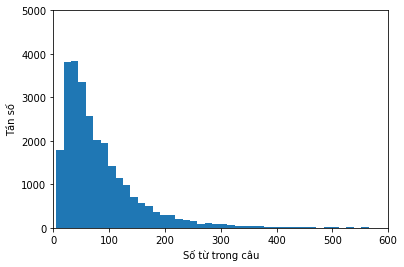

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(num_words, 100)
plt.xlabel('Số từ trong câu')
plt.ylabel('Tần số')
plt.axis([0, 600, 0, 5000])
plt.show()

Dựa trên biểu đồ histogram ở trên chúng ta có thể thấy chọn đặt giới hạn `MAX_SEQ_LENGTH` 200 là tương đối hợp lý. 

In [ ]:
MAX_SEQ_LENGTH = 200

### Chuyển dữ liệu văn bản thành ma trận

Trong phần này, chúng ta sẽ tiến hành biến đổi text của review thành vector index của các từ trong `words_list`. Tập hợp các vector của `train_df` sẽ tạo thành ma trận `train_ids`

In [ ]:
def text2ids(df, max_length, _word_list):
    """
    Biến đổi các text trong dataframe thành ma trận index
    
    Parameters
    ----------
    df: DataFrame
        dataframe chứa các text cần biến đổi
    max_length: int
        độ dài tối đa của một text
    _word_list: numpy.array
        array chứa các từ trong word vectors
    
    Returns
    -------
    numpy.array
        len(df) x max_length contains indices of text
    """
    ids = np.zeros((len(df), max_length), dtype='int32')
    for idx, text in enumerate(tqdm(df['text'])):
        ids[idx,:] = get_sentence_indices(clean_sentences(text), max_length, _word_list)
    return ids

In [ ]:
# LƯU Ý: Bước thực hiện này tương đối mất thời gian (khoảng 5 phút)
# Nếu đã có file train_ids.npy rồi thì ra có thể load lên
# và sử dụng luôn ở bước tiếp theo

print("Converting train_df to train_ids...")
train_ids = text2ids(train_df, MAX_SEQ_LENGTH, words_list)
np.save('train_ids.npy', train_ids)


Converting train_df to train_ids...


In [ ]:
# Trường hợp đã tính toán và lưu ma trận rồi thì ta có thể load lên
train_ids = np.load('train_ids.npy')

In thử word indices của review đầu tiên:

In [ ]:
print('Word indices of the first review: ')
print(train_ids[0])
print(train_ids.shape)

Word indices of the first review: 
[10774 11975  4826  7446  6880 10642  5767 18584 11975  7090  5284  8591
 15213 18109 10642 11022  4690 11975 16032 10630  2465 14595  2750  8231
  2563 10627  7733  9133  3513 19798  2876 10627  1047 12844 13512  7555
 14312 13245  3961   376 19772 15253 16614 17330 17016 10642 14598 15341
  3913 19519  9334 15522 13952 13245  5596 15221 12109 14341 14017   556
 17115 19151 18839 10346  9076 18584 11975  3364     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0    

### Chia dữ liệu thành train, validation và test

Chia dữ liệu `train_ids` và cột `class` của `train_df` thành 3 phần **train : validation : test = 0.8 : 0.1 : 0.1**

In [ ]:
train_x, test_validation_x, train_y, test_validation_y  = train_test_split(train_ids, train_df['class'].astype('int32'), test_size=0.2, random_state=2019)
validation_x, test_x, validation_y, test_y = train_test_split(test_validation_x, test_validation_y, test_size=0.5, random_state=2018)

### TODO 2: Khởi tạo các `train_dataset`, `validation_dataset`, `test_dataset`

In [ ]:
BATCH_SIZE = 256 # Có thể chạy trên Tesla K80 12GB VRAM

In [ ]:
### TODO 2
# Sử dụng các biến đã tạo ở trên, hình thành 3 tập dataset
# train_dataset, validation_dataset, test_dataset
# trong đó mỗi tập dataset đều được chia thành các batch
#
# GỢI Ý:
# Cả 3 tập đều có quy trình tạo như nhau, chỉ khác về tham biến.
#
# Một dataset được tạo như sau:
# dataset_1 = tf.data.Dataset.from_tensor_slices((features,targets))
#
# Các dataset sau đó cần được chia thành batch.
# dataset_1 = dataset_1.batch(batch_size)
#
# Tham khảo: https://www.tensorflow.org/api_docs/python/tf/data/Dataset
### START CODE HERE
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_dataset = train_dataset.batch(BATCH_SIZE)

validation_dataset = tf.data.Dataset.from_tensor_slices((validation_x, validation_y))
validation_dataset = validation_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y))
test_dataset = test_dataset.batch(BATCH_SIZE)
### END CODE HERE

Chạy dòng lệnh sau để kiểm tra TODO 2:

In [ ]:
for idx, (x,y) in enumerate(train_dataset):
    if idx == 0:
        print('FIRST BATCH:')
        print('X =',x)
        print('y =',y)
print("Total: ", idx)

FIRST BATCH:
X = tf.Tensor(
[[12844  5596  4884 ...     0     0     0]
 [10774 16521 13952 ...     0     0     0]
 [ 7446 10698 10774 ...     0     0     0]
 ...
 [ 4884 16995  4601 ...     0     0     0]
 [ 3913 15085 14017 ...     0     0     0]
 [ 4788 14598   310 ...     0     0     0]], shape=(256, 200), dtype=int32)
y = tf.Tensor(
[0 0 1 0 0 1 1 0 0 1 1 1 0 0 1 1 1 0 0 0 1 1 1 0 0 1 0 1 1 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1 1 0 1 1 0 0 1 1 0 1 0 0 1 0 0 1 1 1 0 1 0 1 0 0
 0 1 1 0 1 1 1 0 1 0 0 1 0 0 1 1 0 1 1 0 0 0 1 0 1 0 1 1 1 0 0 1 0 0 1 1 1
 0 1 1 0 1 0 0 0 1 1 0 1 1 1 0 1 0 1 0 0 0 0 0 0 1 0 0 1 1 0 1 1 1 1 1 1 1
 0 0 0 0 0 0 1 1 1 1 0 0 0 1 1 0 1 1 1 1 1 1 0 1 0 1 1 0 0 1 1 1 1 1 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 0 0 0 1 1 1 0
 1 0 1 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 1 0 0 1 1 1 0 1 1], shape=(256,), dtype=int32)
Total:  84


In [ ]:
print(train_dataset)

<BatchDataset shapes: ((None, 200), (None,)), types: (tf.int32, tf.int32)>


Nếu cài đặt đúng, kết quả sẽ có dạng như sau:
```
FIRST BATCH:
X = tf.Tensor(
[[12844  5596  4884 ...     0     0     0]
 [10774 16521 13952 ...     0     0     0]
 [ 7446 10698 10774 ...     0     0     0]
 ...
 [ 4884 16995  4601 ...     0     0     0]
 [ 3913 15085 14017 ...     0     0     0]
 [ 4788 14598   310 ...     0     0     0]], shape=(256, 200), dtype=int32)
y = tf.Tensor(
[0 0 1 0 0 1 1 0 0 1 1 1 0 0 1 1 1 0 0 0 1 1 1 0 0 1 0 1 1 0 0 1 0 0 1 1 0
 0 0 1 0 1 1 1 0 0 0 1 0 1 1 0 1 1 0 0 1 1 0 1 0 0 1 0 0 1 1 1 0 1 0 1 0 0
 0 1 1 0 1 1 1 0 1 0 0 1 0 0 1 1 0 1 1 0 0 0 1 0 1 0 1 1 1 0 0 1 0 0 1 1 1
 0 1 1 0 1 0 0 0 1 1 0 1 1 1 0 1 0 1 0 0 0 0 0 0 1 0 0 1 1 0 1 1 1 1 1 1 1
 0 0 0 0 0 0 1 1 1 1 0 0 0 1 1 0 1 1 1 1 1 1 0 1 0 1 1 0 0 1 1 1 1 1 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 0 0 0 1 1 1 0
 1 0 1 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 1 0 0 1 1 1 0 1 1], shape=(256,), dtype=int32)
Total:  84
```

> *Câu hỏi phụ: số 84 trong kết quả trên nghĩa là gì? Liên hệ trở lại với BATCH_SIZE.*



### Tổng kết quá trình chuẩn bị dữ liệu huấn luyện

Quá trình kết hợp ma trận chỉ số (indices) và ma trận biểu diễn từ (word embeddings) sang data tensor dùng để huấn luyện được mô tả như hình dưới đây:
![caption](https://drive.google.com/uc?export=view&id=1SST9hIt4jboWYr4A41-wI2jMbKI25A9e)

Từ ma trận indices và ma trận embedding, sử dụng `tf.nn.embedding_lookup` ta thu được tensor có kích thước `(BATCH_SIZE, MAX_SEQUENCE_LENGTH, WORD_VEC_DIM)`.


In [ ]:
train_x[0]

array([12844,  5596,  4884, 16995,  3579,  8835,  5596,  5767,  5571,
       16893, 17572,  5519,  8926,  6361,  5767, 17572, 14017, 16521,
        5596,  4884, 13946,   432,  4639, 17572, 13946, 15200,  7456,
       10606,  9445,  8724, 13245,  2036,  6287,  5519,  5695, 11417,
        2036, 13245,  1516,  4884, 13045, 10376,  5519,  2212, 13946,
         184,  1880,  5596,  4884,   255, 16781, 15221,  2212, 12619,
       11777,  9261, 16781, 17677, 18393,   246,  5519,  4884,  4964,
        2212,  4639,  7446, 11694,  4884, 11439, 19898,  8262, 11975,
       13946, 11527,  3364, 18655, 19720, 13215,  3918,  9889,  5013,
        2750, 19193, 10376, 19151,  9962,  8071,  7900,  8136, 13315,
       14723,  5740,  5519,  9076,   119,  4884,  5695,  1355,  9809,
       15605,  8038,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [ ]:
print(train_x[0].shape)
print(train_x.shape)

(200,)
(21600, 200)


In [ ]:
tf.nn.embedding_lookup(word_vectors, train_x[0])

<tf.Tensor: shape=(200, 300), dtype=float32, numpy=
array([[ 0.0292, -0.0241,  0.0796, ...,  0.0008, -0.0218, -0.0077],
       [-0.0076, -0.0454,  0.0488, ..., -0.1456, -0.1232, -0.0259],
       [ 0.021 ,  0.0102,  0.0096, ...,  0.411 , -0.2519,  0.0151],
       ...,
       [ 0.1882, -0.292 ,  0.0072, ...,  0.5919, -0.3094, -0.1228],
       [ 0.1882, -0.292 ,  0.0072, ...,  0.5919, -0.3094, -0.1228],
       [ 0.1882, -0.292 ,  0.0072, ...,  0.5919, -0.3094, -0.1228]],
      dtype=float32)>

In [ ]:
word_vectors.shape

(19899, 300)

In [ ]:
for idx, (x,y) in enumerate(train_dataset):
    if idx == 0:
        print('EMBEDDING OF FIRST BATCH:')
        print(tf.nn.embedding_lookup(word_vectors, x))

EMBEDDING OF FIRST BATCH:
tf.Tensor(
[[[ 2.920e-02 -2.410e-02  7.960e-02 ...  8.000e-04 -2.180e-02 -7.700e-03]
  [-7.600e-03 -4.540e-02  4.880e-02 ... -1.456e-01 -1.232e-01 -2.590e-02]
  [ 2.100e-02  1.020e-02  9.600e-03 ...  4.110e-01 -2.519e-01  1.510e-02]
  ...
  [ 1.882e-01 -2.920e-01  7.200e-03 ...  5.919e-01 -3.094e-01 -1.228e-01]
  [ 1.882e-01 -2.920e-01  7.200e-03 ...  5.919e-01 -3.094e-01 -1.228e-01]
  [ 1.882e-01 -2.920e-01  7.200e-03 ...  5.919e-01 -3.094e-01 -1.228e-01]]

 [[-5.800e-03 -6.460e-02  1.976e-01 ... -1.739e-01  1.770e-02 -2.780e-02]
  [-6.140e-02  4.890e-02  8.530e-02 ... -3.620e-02  4.590e-02 -6.180e-02]
  [ 2.150e-02 -4.110e-02  2.015e-01 ... -9.910e-02 -4.840e-02  6.100e-03]
  ...
  [ 1.882e-01 -2.920e-01  7.200e-03 ...  5.919e-01 -3.094e-01 -1.228e-01]
  [ 1.882e-01 -2.920e-01  7.200e-03 ...  5.919e-01 -3.094e-01 -1.228e-01]
  [ 1.882e-01 -2.920e-01  7.200e-03 ...  5.919e-01 -3.094e-01 -1.228e-01]]

 [[ 4.510e-02 -2.430e-02  2.318e-01 ...  7.880e-02 -5.000e-

Chú ý vào phần shape của tensor output ở trên, ta có thể thấy kích thước của từng batch dữ liệu, tương ứng với hình minh họa trên.

Vậy là ta đã hoàn thành quá trình chuẩn bị dữ liệu!

Tiếp theo, ta sẽ xây dựng mô hình RNN để huấn luyện trên dữ liệu này.

## Xây dựng mô hình RNN

Trong bài tập này, ta sẽ sử dụng mạng Long Short-Term Memory (LSTM), một dạng kiến trúc RNN để gỉải quyết bài toán phân tích cảm xúc.

**Kiến trúc mạng LSTM** ta sẽ sử dụng trong bài tập này được mô tả như hình dưới. Để tăng độ phức tạp của mô hình, ta chồng nhiều tầng LSTM lên nhau (**Stacked LSTM layers**). Giữa tầng LSTM dưới và tầng LSTM trên, ta đặt một lớp dropout.

Việc chồng thêm các tầng LSTM sẽ giúp cho mô hình có khả năng học được các biểu diễn phức tạp hơn (tương tự như khi dùng nhiều tầng CNN), nhưng đồng thời cũng làm tăng số lượng tham số, đồng nghĩa với việc làm tăng thời gian huấn luyện.

![caption](https://drive.google.com/uc?export=view&id=10m5sPPmba__bHx6V9Wp3fp1Wot5uOhBG)

### Chọn  LSTM layer

Để hỗ trợ tốt nhất cho việc tính toán trên GPU, keras hỗ trợ hai loại LSTM layer: 1 loại dành được tối ưu cho các tính toán trên GPU, và một loại dành cho CPU.

In [ ]:
# NEW KERAS LSTM LAYER (suitable for both CPU and GPU): https://keras.io/api/layers/recurrent_layers/lstm/
lstm_layer = tf.keras.layers.LSTM

### TODO 3: Định nghĩa và tạo mô hình
Ở bước này, chúng ta cần định nghĩa mô hình `SentimentAnalysisModel`, kế thừa từ `tf.keras.Model`. Chúng ta sẽ áp dụng mô hình stacked LSTM ở trên để xây dựng `SentimentAnalysisModel`.

Các bạn theo dõi hướng dẫn cụ thể trong code ở dưới.

Hoàn thành hàm `__init__` để tạo định nghĩa của `class SentimentAnalysisModel`.

Hoàn thành hàm `call` để tạo lệnh feedforward khi gọi một `object` của `class SentimentAnalysisModel`.

In [ ]:
class SentimentAnalysisModel(tf.keras.Model):
    """
    Mô hình phân tích cảm xúc của câu
    
    Properties
    ----------
    word2vec: numpy.array
        word vectors 
    lstm_layers: list
        list of lstm layers, lstm cuối cùng sẽ chỉ trả về output của lstm cuối cùng
    dropout_layers: list
        list of dropout layers
    dense_layer: Keras Dense Layer
        lớp dense layer cuối cùng nhận input từ lstm, 
        đưa ra output bằng số lượng class thông qua hàm softmax
    """
    def __init__(self, word2vec, lstm_units, n_layers, num_classes, dropout_rate=0.25):
        """
        Khởi tạo mô hình
        
        Paramters
        ---------
        word2vec: numpy.array
            word vectors 
        lstm_units: int
            số đơn vị lstm
        n_layers: int
            số layer lstm xếp chồng lên nhau
        num_classes: int
            số class đầu ra
        dropout_rate: float
            tỉ lệ dropout giữa các lớp
        """
        super().__init__(name='sentiment_analysis')
        
        # Khởi tạo các đặc tính của model
        self.word2vec = word2vec
        self.n_layers = n_layers
        self.lstm_layers = []  # List chứa các tầng LSTM
        self.dropout_layers = []  # List chứa các tầng dropout

        ### TODO 3.1
        # Vòng lặp dưới chạy qua N tầng trong stack
        # mỗi tầng sẽ có 1 lstm_layer và 1 dropout_layer
        # 
        # Khởi tạo lstm_layer như sau: 
        # new_lstm = tf.keras.layers.LSTM(units=..., return_sequence=... )
        # Tham khảo: https://keras.io/api/layers/recurrent_layers/lstm/
        # LƯU Ý:
        # return_sequence của lstm_layer nhận giá trị True ở mọi tầng  
        # trong stack, ngoại trừ tầng cuối cùngg
        #
        # Khởi tạo dropout_layer như sau:
        # new_dropout = tf.keras.layers.Dropout(rate=...)
        # Tham khảo: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout
        # 
        # Sau khi khởi tạo lstm_layer và dropout_layer
        # hãy thêm chúng vào 2 list tương ứng
        # self.lstm_layers và self.dropout_layers
        #
        # Cuối cùng, khởi tạo tầng fully-connected/dense
        # tf.keras.layers.Dense(num_classes=..., activation=' ')
        # Tham khảo: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense
        #
        ### START CODE HERE
        for i in range(n_layers):
            if i == n_layers-1:
              new_lstm = tf.keras.layers.LSTM(units= lstm_units, return_sequences= False)
            else:
              new_lstm = tf.keras.layers.LSTM(units= lstm_units, return_sequences= True)
            self.lstm_layers.append(new_lstm)

            new_dropout = tf.keras.layers.Dropout(rate= dropout_rate)
            self.dropout_layers.append(new_dropout)
        
        self.dense_layer = tf.keras.layers.Dense(units=num_classes, activation='softmax', name='dense_0')
        ### END CODE HERE
        
    def call(self, inputs):
        ### TODO 3.2
        # Thực hiện các bước biến đổi khi truyền thuận input qua mạng
        # Điền code vào các đoạn pass
        ### START CODE HERE

        

        # Input hiện là indices, cần chuyển sang dạng vector
        # sử dụng:
        # tf.nn.embedding_lookup(embeddings, indices)
        inputs = tf.nn.embedding_lookup(self.word2vec, inputs)
      
        # Truyền thuận inputs lần lượt qua các tầng
        # ở mỗi tầng, truyền input qua các layer: lstm > dropout
        # vd: x = first_lstm(x)
        #     x = first_dropout(x)
        #     x = second_lstm(x)
        #     v.v.
        x = inputs
        for i in range(self.n_layers):
          x = self.lstm_layers[i](x)
          x = self.dropout_layers[i](x)
        
        # Gán giá trị tầng cuối cùng vào out và trả về
        out = self.dense_layer(x)
        
        return out
        ### END CODE HERE
        

Tiếp theo, ta lựa chọn các hyperparameters (siêu tham số) phù hợp, rồi tạo mô hình dựa trên định nghĩa.

In [ ]:
# Các hyperparameters
LSTM_UNITS = 128
N_LAYERS = 2
NUM_CLASSES = 2

In [ ]:
model = SentimentAnalysisModel(word_vectors, LSTM_UNITS, N_LAYERS, NUM_CLASSES)

##### SANITY CHECK FOR TODO3

In [ ]:
# Expected output is a Tensor of shape (5,2)
# corresponding to the probability of classes 0 and 1, ie. negative and positive, for 5 samples
model(train_x[0:5])

<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[0.4922215 , 0.50777847],
       [0.49222147, 0.5077785 ],
       [0.4922215 , 0.5077785 ],
       [0.4922215 , 0.5077785 ],
       [0.49222147, 0.5077785 ]], dtype=float32)>

In [ ]:
train_x[0:5].shape

(5, 200)

In [ ]:
train_x.shape

(21600, 200)

> *Câu hỏi phụ: Hãy thử ước tính xem mô hình với các siêu tham số trên sẽ có bao nhiêu tham số cần huấn luyện, với kích thước input là 200? Kiểm tra bằng `model.summary()`.*


In [ ]:
model.summary()

Model: "sentiment_analysis"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  multiple                  219648    
_________________________________________________________________
lstm_1 (LSTM)                multiple                  131584    
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_0 (Dense)              multiple                  258       
Total params: 351,490
Trainable params: 351,490
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.summary()

Model: "sentiment_analysis"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  multiple                  219648    
_________________________________________________________________
lstm_1 (LSTM)                multiple                  131584    
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_0 (Dense)              multiple                  258       
Total params: 351,490
Trainable params: 351,490
Non-trainable params: 0
_________________________________________________________________


### Huấn luyện mô hình

Ở bài tập 3 (CNN), ta đã sử dụng hàm `fit` của keras model trong quá trình huấn luyện.

Ở bài tập này, quá trình huấn luyện được thực hiện ở cấp độ thấp hơn (lower level), và ta sẽ đi qua từng bước: **truyền thuận**, **truyền ngược**, và **tối ưu hoá**

Đầu tiên, chọn các tham số huấn luyện:

In [ ]:
LEARNING_RATE = 0.001
EPOCHS = 100

Ta sẽ sử dụng thuật toán tối ưu hoá Adam với learning rate là `LEARNING_RATE`:

> Tham khảo thêm về Adam ở các link dưới:
>  * tiếng Anh: https://ml-cheatsheet.readthedocs.io/en/latest/optimizers.html#adam
>  * tiếng Anh: http://ruder.io/optimizing-gradient-descent/index.html#adam
>  * tiếng Việt: https://viblo.asia/p/thuat-toan-toi-uu-adam-aWj53k8Q56m



In [ ]:
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

Các biến khác hỗ trợ cho việc huấn luyện:

In [ ]:
# Thư mục chứa checkpoint
checkpoint_dir = './model'
# Mẫu tên checkpoint
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{score}")

#### TODO 4: Viết hàm huấn luyện từng epoch

Trước tiên, ta sẽ import vài thành phần từ thư viện `fastprogress` để tiện cho việc biểu diễn 
quy trình huấn luyện:

In [ ]:
from fastprogress import master_bar, progress_bar

Ta cần xây dựng hàm `epoch_training`, thực hiện các bước **truyền thuận**, **truyền ngược** và **tối ưu hóa** tại mỗi epoch.

Hàm `epoch_training`:
* nhận các tham biến `model`, `dataset`, `mb`, và `num_step`
* trả về giá trị loss trung bình của model

In [ ]:
def epoch_training(model, dataset, mb, num_step):
    """
    Huấn luyện mô hình trong 1 epoch
    
    Parameters
    ----------
    model: tf.keras.Model
        model cần huấn luyện
    dataset: tf.Dataset
        dataset dùng để huấn luyện
    mb: fastprogress.master_bar
        thanh biểu diễn tiến độ
    num_step: int
        số bước lặp trong mỗi epoch
    Returns
    -------
    float
        Giá trị loss trung bình của epoch
    """
    train_losses = [] # Chứa giá trị loss của các batch
    dataset_iter = iter(dataset)
    for batch in progress_bar(range(num_step), parent=mb):
        inp, target = next(dataset_iter)
        ### TODO 4
        # tham khảo cách dùng tf.GradientTape ở def train_step()
        # ở link https://www.tensorflow.org/guide/migrate#customize_the_training_step
        with tf.GradientTape() as tape:
            
            ### TODO 4.1
            # Truyền thuận - Feedforward
            # Để tạo giá trị predictions
            ### START CODE HERE
            predictions = model(inp, training=True)
            ### END CODE HERE
            
            ### TODO 4.2
            # Tính loss giữa target và predictions
            # sử dụng hàm loss sparse_softmax_cross_entropy
            ### START CODE HERE
            # regularization_loss=tf.math.add_n(model.losses)
            loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

            loss = loss_fn(target, predictions)
            # loss = regularization_loss + loss
            ### END CODE HERE
          
            # Thêm loss của batch vào train_losses
            train_losses.append(loss)
            
        
        
        ### TODO 4.3
        # Tính gradient của loss theo các tham số của mô hình
        ### START CODE HERE
        gradients = tape.gradient(loss, model.trainable_variables)
        ### END CODE HERE
        
        ### TODO 4.4
        # Dùng gradient để tối ưu các tham số
        ### START CODE HERE
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        ### END CODE HERE
        
        mb.child.comment = 'Train loss {:.4f}'.format(loss)
        
    # Trả về loss trung bình
    return sum(train_losses)/ len(train_losses)

#### SANITY CHECK FOR TODO 4

In [ ]:
# Test epoch_training() over one trial epoch
mb = master_bar(range(1))
for epoch in mb:
  print(epoch_training(model, train_dataset, mb, math.ceil(len(train_x)*1.0/BATCH_SIZE)))

tf.Tensor(0.6949676, shape=(), dtype=float32)


#### TODO 5: Viết hàm đánh giá từng epoch

Ta cần xây dựng hàm `epoch_evaluation`, thực hiện duy nhất bước **truyền thuận** để tính loss.

Hàm `epoch_evaluation`:
* nhận vào `model`, `dataset`, `mb`, và `num_step`
* trả về giá trị `loss`, `f1_score` của model trên tập `dataset` 

In [ ]:
def epoch_evaluation(model, dataset, mb, num_step):
    """
    Đánh giá mô hình qua 1 epoch
    
    Parameters
    ----------
    model: tf.keras.Model
        model cần đánh giá
    dataset: tf.Dataset
        dataset cần đánh giá
    mb: fastprogress.master_bar
        progess bar
    num_step: int
        số bước lặp trong mỗi epoch
    Returns
    -------
    float
        Giá trị loss trung bình của epoch
    float
        Giá trị F1-score trên tập validation
    """
    val_losses = []   # Chứa giá trị loss của các batch
    val_gt = []       # Chứa giá trị nhãn thật của tập validation , gt = groundtruth
    val_pred = []     # Chứa giá trị nhãn dự đoán do model trên tập validation
    dataset_iter = iter(dataset)
    for batch in progress_bar(range(num_step), parent=mb):
        inp, target = next(dataset_iter)
        
        val_gt.extend(target.numpy().astype(np.int32).tolist())
        ### TODO 5.1
        # Truyền thuận
        # để lấy predictions
        ### START CODE HERE
        predictions = model(inp, training=False)
        ### END CODE HERE
        
        ### TODO 5.2
        # Tính loss giữa target và predictions
        # sử dụng hàm loss sparse_softmax_cross_entropy
        ### START CODE HERE
        # regularization_loss=tf.math.add_n(model.losses)
        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

        loss = loss_fn(target, predictions)
        # loss = regularization_loss + loss
        ### END CODE HERE
        
        
        # Thêm loss vào val_losses
        val_losses.append(loss)
        val_pred.extend(tf.argmax(predictions,1).numpy().astype(np.int32).tolist())
        
        mb.child.comment = 'Validation loss {:.4f}'.format(loss)
    # Trả về loss trung bình và F1-score
    return sum(val_losses) / len(val_losses), f1_score(val_gt, val_pred)

#### SANITY CHECK FOR TODO 5

In [ ]:
# Test epoch_evaluation() over one trial epoch
mb = master_bar(range(1))
for epoch in mb:
  val_loss, val_score = epoch_evaluation(model, validation_dataset, mb, math.ceil(len(validation_x)*1.0/BATCH_SIZE))
print(val_loss)
print(val_score)

tf.Tensor(0.69419765, shape=(), dtype=float32)
0.6472120896300156


#### TODO 6: Thiết lập quy trình huấn luyện


Khi đã chuẩn bị xong hàm huấn luyện và đánh giá cho mỗi epoch, ta có thể thiết lập quy trình huấn luyện chính.

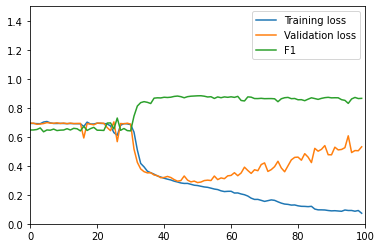

In [ ]:
best_score = 0
mb = master_bar(range(EPOCHS))
mb.names = ['Training loss', 'Validation loss', 'F1']
training_losses = []
validation_losses = []
f1_scores = []
x = []

train_step = math.ceil(len(train_x)*1.0/BATCH_SIZE)
val_step = math.ceil(len(validation_x)*1.0/BATCH_SIZE)
for epoch in mb:
    # initializing the hidden state at the start of every epoch
    # initally hidden is None
    hidden = model.reset_states()
    x.append(epoch)
    
    ### TODO 6.1
    # Huấn luyện bằng hàm epoch_training()
    # Sử dụng tập train_dataset
    ### START CODE HERE
    training_loss = epoch_training(model, train_dataset, mb, train_step)
    ### END CODE HERE
    
    # Báo cáo kết quả train/huấn luyện
    mb.write('Finish train epoch {} with loss {:.4f}'.format(epoch, training_loss))
    training_losses.append(training_loss)
    
    ### TODO 6.2
    # Đánh giá kết quả trên tập validation_dataset
    # bằng hàm epoch_evaluation()
    ### START CODE HERE
    valid_loss, valid_score = epoch_evaluation(model, validation_dataset, mb, val_step)
    ### END CODE HERE
    
    # Báo cáo kết quả validate
    mb.write('Finish validate epoch {} with loss {:.4f}, F1-score {:.4f}'.format(epoch,valid_loss, valid_score))
    validation_losses.append(valid_loss)
    f1_scores.append(valid_score)
    
    # Cập nhật đồ thị
    mb.update_graph([[x, training_losses], [x, validation_losses], [x, f1_scores]], [0,EPOCHS], [0,1.5])
    
    # Update score và lưu model có score tốt nhất
    if best_score < valid_score:
        mb.write(">>> Improved F1-score from {:.4f} to {:.4f}".format(best_score, valid_score))
        # Update best_score
        best_score = valid_score
        # Save model
        model.save_weights(checkpoint_prefix.format(score=valid_score))
        
    

### Đánh giá mô hình trên tập test có nhãn

Sau khi hoàn thành quá trình huấn luyện, ta sẽ đánh giá mô hình trên tập test đã chia ra từ dữ liệu có nhãn. Ta sử dụng thang điểm F1 để đánh giá độ chính xác của mô hình.

> Tham khảo về định nghĩa F1-score ở đây: https://machinelearningcoban.com/2017/08/31/evaluation/#-f-score
![alt text](https://machinelearningcoban.com/assets/33_evaluation/PR.png)

Nếu được huấn luyện đúng cách thì kết quả F1 ở phần này sẽ rơi vào khoảng 70-80% trở lên.

In [ ]:
mb = master_bar(range(1))
for i in mb:
  test_loss, test_score = epoch_evaluation(model, test_dataset, mb, math.ceil(len(test_x)*1.0/BATCH_SIZE))
print("F1-score on test set:", test_score)

F1-score on test set: 0.8639718804920913


## Predict trên 3000 mẫu bình luận không nhãn

Đã xong quá trình huấn luyện và kiểm định mô hình trên dữ liệu có nhãn.

Nếu thực hiện tốt các bài tập ở trên, thì đến đây bạn đã có một mô hình có thể phân tích cảm xúc tiêu cực/tích cực của một đoạn văn bản tiếng Việt bất kì!

(Tuy nhiên, nếu văn bản đó không phải là bình luận về địa điểm ăn uống thì mô hình sẽ khó lòng dự đoán chính xác, bởi dữ liệu mà ta dùng để huấn luyện chỉ nằm trong miền các bình luận đánh giá quán ăn. Có thể nói là mô hình của chúng ta chỉ có tri thức chuyên biệt về địa điểm ăn uống.)

Việc cuối cùng là áp dụng mô hình để suy đoán cảm xúc của các mẫu bình luận không nhãn.

In [ ]:
#Các bình luận không nhãn
test_df.head(10)

,id,text
0,2017ec48,"Mình kêu 6 loại khác nhau , mỗi laoij 1 cục mà ăn cái nào cũng như nhau , cứ như đang ăn 1 loại vậy . Cuối cùng ngon nhất lại là cục khoai môn chiên . Mấy loại há cảo xíu mại bánh xẹp ăn ngán cực kỳ , mà làm cục to tổ bố để ép khách mua với cái giá 19k . Ko hiểu ăn được cái gì ở đây mà có người khen ngon"
1,e3f0ea32,"Ăn ở đây từ trc khi chủ nhà xây nhà mới . chất lg ko đổi còn giá có tăng từ từ 1-2k : ) )\nphần mìh kiu là 2 thường 2 trứng 22k - hơi no tẹo và CỰC KÌ NGONNN > <\nđi vạn kiếp rẽ vào hẻm có biển hoa đàm ni tự và đi chừng 50m là tới , vì hẻm 2m nên để xe bên ngoài dọc theo 2 dãy nhà , chú chủ sẽ sắp xếp xe lại nhưng mình khuyến khích các b mua về : ) ) ăn tại chỗ thì bàn ghế sạch sẽ , ly uống nước là loại dùng 1 lần - > kết điểm này ! ! !\nphục vụ của 2 vk ck chủ thì miễn bàn , cực kì thân thiện . dạo này có 1 cô nữa phụ bán nhưng ko dc lanh lẹ lắm .\n* quán chỉ bán buổi sáng tới chừng 9-10g là hết . lâu lâu thì 11g .\n* hành phi tự làm ngon và giòn lắm nhé ^ ^ còn bánh cuốn thì gọi tới đâu làm tới đó , ko qá lâu và bánh còn ấm ."
2,8743eae3,"Các bạn đến ăn ngay và luôn đi nhé ! !\nMình từ trước giờ chỉ Súp cua Súp óc heo làm tới , từ khi tới quán , mình đã biết thêm nhiều loại khác ( rong biển , hến , thập cẩm , . . mới đây còn có thêm súp còi điệp ) . Không chỉ có súp không âu nha , nhìn menu mà món nào cũng muôn ăn ... Ah , bánh Flan trà xanh cực ngon luôn , món khoái khẩu của mình ấy ... Mình không có thói quen chộp hình thức ăn trước khi ăn , nên các bạn đến ngay SÚP SÀI GÒN Q4 và cảm nhận nhé ^ ^"
3,7b554248,"Đây gần như quán ruột của mình luôn : ) ) đây đồ ăn ngon , nhân viên dễ thương , mấy anh giữ xe phía ngoài cũng dễ thương ko kém : ) ) giá cả thì hợp lý khỏi bàn luôn rồi . Đây là 3 món ruột , lần nào đến cũng phải ăn : ) ) ) hahaaa"
4,bedd1403,"Tiếc là 25 năm sống ở Tây Ninh thì đây là lần đầu tiên mình ghé .\nThức ăn rất Việt Nam , ngon và vị tuyệt vời , giá hợp lý .\nKhuyết điểm :\nGiờ cơm trưa quán đắc nên đợi rất lâu ,\nMình quên giử số điện thoại để đặt chổ và thức ăn trước , a e ai ghé thì thêm vào giúp .\nHơi nóng , và chắc vì quán đông quá nên phần mỷ quan có điễm trừ ,"
5,8bbfd5a7,"Vâ ̃ n la ̀ Ze ́ , Ze ́ luôn nhâ ́ t 👍\nCuô ́ i tuâ ̀ n no nê vơ ́ i my ̀ ga ̀ phô mai , sushi , ga ̀ ra ́ n thanh cua , soda va ̀ xoa ̀ i lă ́ c\nPha ̉ i no ́ i la ̀ sau ca ́ i mo ́ n ba ̣ ch tuô ̣ c xa ̀ o cay thi ̀ my ̀ ga ̀ phô mai la ̀ ca ́ i mo ́ n gây nghiê ̣ n nhâ ́ t 😍 my ̀ mê ̀ m dai co ́ vi ̣ cay cay , cu ̀ ng vơ ́ i ga ̀ viên gio ̀ n gio ̀ n 👍 yêu ca ́ i mo ́ n na ̀ y\nXoa ̀ i lă ́ c , đâu đâu cu ̃ ng xoa ̀ i lă ́ c , ma ̀ bư ̃ a nay mơ ́ i ăn xoa ̀ i lă ́ c cu ̉ a ze ́ , hi ̀ nh như la ̀ chung công thư ́ c hay sao nên thâ ́ y ăn chô ̃ na ̀ o cu ̃ ng giô ́ ng nhau , xoa ̀ i ngon , vi ̣ vư ̀ a ăn , ko qua ́ cay hay qua ́ mă ̣ n , nhưng co ́ miê ́ ng gio ̀ n miê ́ ng thi ̀ mê ̀ m 😢 mi ̀ nh la ̣ i thi ́ ch gio ̀ n hơn , nhưng to ́ m la ̣ i la ̀ vâ ̃ n ngon\nChu ̉ nhâ ̣ t , ma ̀ không pha ̉ i riêng chu ̉ nhâ ̣ t , buô ̉ i tô ́ i la ̀ ze ́ đông ơi la ̀ đông , nhưng ma ̀ phu ̣ c vu ̣ vâ ̃ n nhanh nhe ̣ n , nhiê ̣ t ti ̀ nh , thi ́ ch dê ̃ sơ ̣\nTô ́ i nay chă ́ c ngu ̉ không ..."
6,1b85aa7f,"Nhà hàng đẹp , không gian rộng , có phòng riêng .\nSo với mặt bằng và vị trị thì giá cả như vậy là hợp lí , nhưng giá thức uống thì hơi cao .\nNhóm 7 người order 1combo dành cho 2 người rồi gọi thêm 1 phan kim chi , linh tinh cac rau củ nướng , 1 phan bò mỹ , 1ga lá quế phô mai ( ngon ) , sashimi cá hồi , 1 sụn gà chien gion ( lượng hơi it , giá hơi cao , ngon nhưng hơi lạt 1 chút ) , 1 cơm trộn ( ko co j dac biet , ko ngon lam ) , 1 cái lẩu miso , nuoc uong . Phải nói là ăn ngập mặt thịt thà luôn , cả đám ngán thịt lun , no muon lăn về .\nPhải công nhận là cái combo đó wa chất lượng và đáng đồng tien lam nha , nhìn hình tưởng ít , ai dè lên món thay qua troi , neu 2 ng mà ăn 1combo cho 2ng chac no căng bụng lun .\nNhà hàng có chuong trinh 1 nguoi check in & like page = tặng 50gr , nhóm mình 7ng check in

### TODO 7: Xây dựng hàm `predict`

Ta cần viết một hàm nhận vào một câu/đoạn bình luận tiếng Việt, và trả về một trong 2 giá trị cảm xúc positive hoặc negative.

Cần lưu ý: các dữ liệu không nhãn chưa được tách thành từ nên các bạn cần sử dụng các thư viện hỗ trợ tokenize tiếng Việt (ví dụ underthesea) để tiền xử lý trong hàm `predict`

In [ ]:
try:
    from underthesea import word_tokenize
except:
    !pip install underthesea
    from underthesea import word_tokenize

     |████████████████████████████████| 7.5MB 12.2MB/s 
     |████████████████████████████████| 1.3MB 60.2MB/s 
     |████████████████████████████████| 245kB 52.7MB/s 
     |████████████████████████████████| 753.2MB 23kB/s 
     |████████████████████████████████| 51kB 805kB/s 
     |████████████████████████████████| 747kB 44.9MB/s 
     |████████████████████████████████| 2.9MB 45.9MB/s 
     |████████████████████████████████| 870kB 48.7MB/s 
     |████████████████████████████████| 1.1MB 47.5MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp37-none-any.whl size=16172 sha256=6b5eefd16b35ca3350cefefe2aad8bf796f850eadbb24738a648e033bc2bab90
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=a7df6ae6c26e16329292b6b4d1eb18616a73c0b6244c94f87a5010f9fe9009e5
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f44836

In [ ]:
def predict(sentence, model, _word_list=words_list, _max_seq_length=MAX_SEQ_LENGTH):
    """
    Dự đoán cảm xúc của một câu
    
    Parameters
    ----------
    sentence: str
        câu cần dự đoán
    model: model keras
        model keras đã được train/ load trọng số vừa train
    _word_list: numpy.array
        danh sách các từ đã biết
    _max_seq_length: int
        giới hạn số từ tối đa trong mỗi câu
        
    Returns
    -------
    int
        0 nếu là negative, 1 nếu là positive
    """
    ### TODO 7.1
    # Tokenize/Tách từ trong câu
    # Sử dụng hàm word_tokenize vừa import ở trên
    ### START CODE HERE
    word_token = word_tokenize(sentence, format='text')
    ### END CODE HERE
    
    ### TODO 7.2
    # Đưa câu đã tokenize về dạng input_data thích hợp để truyền vào model
    ### START CODE HER
    input_data = get_sentence_indices(word_token, _max_seq_length, _word_list)
    ### END CODE HERE
    
    
    ### TODO 7.3
    # Truyền input_data qua model để nhận về xác suất các nhãn
    # Chọn nhãn có xác suất cao nhất và return
    ### START CODE HERE
    predictions = np.argmax(model(input_data),1)[0]
    return predictions
    ### END CODE HERE

In [ ]:
word_tokenize('nhà hàng nay ngon')

['nhà hàng', 'nay', 'ngon']

In [ ]:
word_tokenize('nhà hàng nay ngon', format='text')

'nhà_hàng nay ngon'

In [ ]:
test_df['text'][0]

'Mình kêu 6 loại khác nhau , mỗi laoij 1 cục mà ăn cái nào cũng như nhau , cứ như đang ăn 1 loại vậy . Cuối cùng ngon nhất lại là cục khoai môn chiên . Mấy loại há cảo xíu mại bánh xẹp ăn ngán cực kỳ , mà làm cục to tổ bố để ép khách mua với cái giá 19k . Ko hiểu ăn được cái gì ở đây mà có người khen ngon'

In [ ]:
train_df['text'][0]

'Đến quán 2 lần thôi , rất là thích !\nQuán tuy nằm trong hẻm nhưng rất dễ tìm , quán rộng_rãi thoáng mát sạch_sẽ .\nNhân_viên phục_vụ nhiệt_tình , siêu dễ_thương .\nThực_đơn phong_phú đa_dạng , giá siêu rẻ .\nThức_ăn nêm nếm hợp_khẩu vị , ngon_miệng .\nDesert ngọt vừa , không quá ngấy , rất ngon .\nTrà sữa , uyên_ương thơm và đúng vị mình đã từng uống ở HongKong .\nNói_chung điểm 10 cho chất_lượng , thích quán lắm !'

Load trọng số model đã train:

In [ ]:
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

Kiểm tra hàm vừa cài đặt, nếu cài đặt hàm và huấn luyện đúng thì kết quả lần lượt **_nên_** là 0 và 1.

In [ ]:
print("Test 1:",predict("Quán này rất dở", model))
print("Test 2:",predict("Quán này rất ngon", model))

Test 1: 0
Test 2: 1


### Ghi kết quả

Đọc file `sample_submission.csv`

In [ ]:
submission = pd.read_csv(data_dir+"/sample_submission.csv", index_col=0)
submission.head()

,class
id,
2017ec48,0
e3f0ea32,0
8743eae3,0
7b554248,0
bedd1403,0


Duyệt từng dòng trong DataFrame `test_df` và dự đoán sau đó cập nhật kết quả vào `submission`

In [ ]:
for _, row in tqdm(test_df.iterrows()):
    submission.loc[row.id] = predict(row.text, model)

In [ ]:
submission.head(20)

,class
id,
2017ec48,1
e3f0ea32,1
8743eae3,1
7b554248,1
bedd1403,1
8bbfd5a7,1
1b85aa7f,1
dde11e38,1
efebda46,1


### Nộp bài

Xuất ra file `submission.csv`.

In [ ]:
submission.to_csv('submission.csv')

Các bạn nộp file submission lên [Kaggle competition](https://www.kaggle.com/c/vietai-f7-assignment-4/)